In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Métodos numéricos

<img src="figures/LogoCinvestav.png" style="height:100px" title="Cinvestav">

**CINVESTAV Unidad Saltillo**

**Curso Propedeutico del Programa de Maestría en Ciencias en Ingeniería Metalúrgica**

Dr. Edgar Ivan Castro Cedeño



Contacto:
[edgar.castro@cinvestav.mx](mailto:edgar.castro@cinvestav.mx)

### 6.1.2 Ejemplos

#### 6.1.2.1 Ecuación de conducción de calor (régimen estacionario)

$$\frac{d^2T}{dx^2} + h^{\prime}\left(T_{a} - T\right) = 0$$

$$T(0) = T_1$$

$$T(L) = T_2$$



<center>

<img src="figures/images/barConvective1D.png" style="height:200px" title="Finite difference stencil">

***Figura 02. Esquema auxiliar para representación del problema de conducción de calor.***

</center>

**Discretización de la ecuación por el método de diferencias finitas:**

$$\frac{T_{i-1} + T_{i+1} - 2T_{i}}{(\Delta x)^2} + h^{\prime} \left(T_{\infty}-T_{i}\right) = 0$$


Reordenando se obtiene la ecuación lineal:

$$-T_{i-1} + \left(2+h^{\prime}(\Delta x)^2\right) T_{i} - T_{i+1} = h^{\prime}(\Delta x)^2 T_{a}$$

#### 6.1.2.2 Problema de aplicación

Resuelva el problema de conducción de calor en régimen estacionario, considerando una barra de $10\,m$ con un coeficiente de transferencia de calor $h^{\prime}=0.01\,m^{-2}$, $T_{a}=20$, y condiciones a la frontera:

$$T(0) = 40$$
$$T(10) = 200$$

Usando cuatro nodos interiores con un segmento de longitud $\Delta x = 2 \, m$.

<center>

<img src="figures/images/finiteDifference1DProblem.png" style="height:300px" title="Finite difference stencil">

***Figura 03. Esquema auxiliar para representación del mallado para el problema de conducción de calor.***

</center>

**Solución:**



Cálculo de coeficientes para construir el sistema de ecuaciones:

$$h^{\prime}(\Delta x)^2 = 0.04$$

$$\left(2+h^{\prime}(\Delta x)^2\right) = 2.04$$

$$h^{\prime}(\Delta x)^2 T_{a} = 0.8$$

Escritura de ecuaciones para cada nodo:

$$2.04 T_1 - T_2 = 0.8 + 40$$

$$-T_1 + 2.04 T_2 - T_3 = 0.8$$

$$-T_2 + 2.04 T_3 - T_4 = 0.8$$

$$-T_3 + 2.04 T_4 = 0.8 + 200$$

Escritura en forma matricial:

$$\begin{pmatrix} 2.04 & -1 & 0 & 0 \\ -1 & 2.04 & -1 & 0 \\ 0 & -1 & 2.04 & -1 \\ 0 & 0 & -1 & 2.04 \end{pmatrix} \begin{pmatrix} T_1 \\ T_2 \\ T_3 \\ T_4 \end{pmatrix} = \begin{pmatrix} 40.8 \\ 0.8 \\ 0.8 \\ 200.8 \end{pmatrix}$$

#### Solución con `scipy`, escribiendo la matriz completa

In [2]:
from scipy.linalg import solve

In [3]:
A = np.array([[2.04, -1, 0, 0], 
              [-1, 2.04, -1, 0],
              [0, -1, 2.04, -1],
              [0, 0, -1, 2.04]])
b = np.array([40.8, 0.8, 0.8, 200.8])

T = solve(A, b)
print(T)

[ 65.96983437  93.77846211 124.53822833 159.47952369]


#### Solución con `scipy`, escribiendo como matriz dispersa

In [4]:
from scipy.sparse import diags_array
from scipy.sparse.linalg import spsolve

In [5]:
dp = np.array([2.04, 2.04, 2.04, 2.04])
dl = np.array([-1, -1, -1])
du = np.array([-1, -1, -1])
A = diags_array([dp, dl, du], offsets=[0, -1, 1], format='csc')
b = np.array([40.8, 0.8, 0.8, 200.8])

T4 = spsolve(A, b)
print(T4)

[ 65.96983437  93.77846211 124.53822833 159.47952369]


#### 6.1.2.3 Parametrización del problema

El problema se puede parametrizar de tal forma que se pueda obtener de forma algorítmica una solución para un número arbitrario de nodos.

In [6]:
# parámetros de entrada
L = 10 # tamaño del dominio [m]
n = 20  # número de nodos en el sistema
h = 0.01 # coeficiente de transferencia de calor, [m-2]
Ta = 20 # Temperatura ambiente "lejos de la barra"
T0 = 40 # Temperatura en x=0
TL = 200 # Temperatura en x=L


In [7]:
# cálculo de coeficientes para construir el sistema de ecuaciones
dx = L/(n+1)
hdx2 = h*(dx)**2
hdx2Ta = hdx2*Ta

In [8]:
# construcción de la matriz A (LHS)
dp = (2+hdx2) * np.ones(shape=(n))
dl = -1 * np.ones(shape=(n-1))
du = -1 * np.ones(shape=(n-1))
A = diags_array([dp, dl, du], offsets=[0, -1, 1], format='csc')

# construcción del vector b (RHS)
b = hdx2Ta * np.ones_like(dp)
b[0] += T0
b[-1] += TL

# solución del sistema
T = spsolve(A, b)

In [10]:
def Tlin(x, T0, TL, L):
    return T0 + (TL-T0)/(L) * x

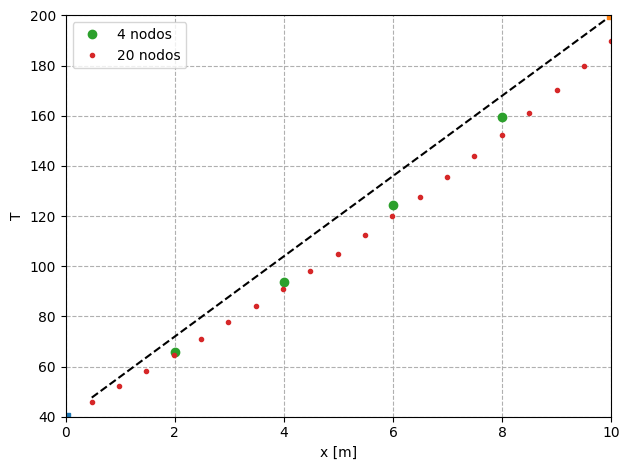

In [11]:
fig, ax = plt.subplots()

x = np.linspace(dx, L, n)
y = T

ax.plot(x, Tlin(x,T0, TL, L), color='k', ls='--')
ax.plot(0, T0, ls='', marker='s')
ax.plot(L, TL, ls='', marker='s')
ax.plot([2, 4, 6, 8], T4, ls='', marker='o', label='4 nodos')
ax.plot(x, y, ls='', marker='.', label=f'{n} nodos')
ax.set(xlim=(0, L), ylim=(T0, TL),
       xlabel='x [m]', ylabel='T')
ax.legend()
ax.grid(ls='--')
fig.tight_layout()
plt.show()